### Maxwell A. Fine 14880725
### Assingment 3: Stastical Methods in Astrophysics

In [136]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
import scipy.integrate as spint
import scipy.interpolate as spinterp
from scipy.integrate import simps
from uncertainties import ufloat
from scipy.optimize import curve_fit
from lmfit import Model

# Set a seed for reproducibility
random_seed = 50

# Gaia correction term
gaia_corr = 0.029 # mas

assigned_clusters = ['NGC_6611', 'NGC_1817', 'NGC_663']



# Task 1:
First, make stellar density profiles for each of your three clusters. To do this, you first need to create a
new column in your dataframe which contains the radial separation of each star (in arcseconds) from
the centre of its cluster, i.e. � = 3600. '(� − �̅)! + (� − �/)! where � and � are the RA and DE
positions of the star (in degrees) and �̅and �/ are the means of RA and DE for all the stars in the
cluster (i.e. the estimated location of the centre of the cluster). 

Then, use the radial locations of the
stars to make a histogram of stellar number density �∗ vs. radius, that is, the number of stars in a
radial bin, normalized by the area of the radial bin, which will correspond to an annulus on the sky
(use arcsec2 as the units of area). Choose appropriate radial binning and plot the stellar density
profiles (and error bars, if appropriate) for your 3 clusters on separate plots.

### Idea:

### Assumptions:

In [4]:
# Load in Data
# This time I am using _df to indicate it is a pandas df
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars_df = pd.DataFrame(dr3stars[1].data)
stars_df['Name'] = stars_df['Name'].str.strip()
clcounts = stars_df.groupby(['Name']).size().reset_index(name='count') 


# Lets calculate Mean Ra, Dec for the clusters and add it as a Col in the df
stars_df['cluster_mean_RAdeg'] = stars_df.groupby('Name')['RAdeg'].transform('mean')
stars_df['cluster_mean_DEdeg'] = stars_df.groupby('Name')['DEdeg'].transform('mean')

# Lets compute radial dinstance (in deg) of each star from the estimated cluster center (the means) and add it as a Col 
# Double check this works as intended 
stars_df['radial_separation_arcsec'] = 3600 * np.sqrt((stars_df['RAdeg'] - stars_df['cluster_mean_RAdeg'])**2
                                    + (stars_df['DEdeg'] - stars_df['cluster_mean_DEdeg'])**2)  # 3600 is the conversion factor 

# grab assigned star clusters
assigned_clusters_df = stars_df[stars_df['Name'].isin(assigned_clusters)]


Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   
ColDefs(
    name = 'Name'; format = 'A20'; start = 1
    name = 'ID'; format = 'I4'; disp = 'I4'; start = 22
    name = 'GaiaDR3'; format = 'I19'; disp = 'I19'; start = 27
    name = 'inrt'; format = 'I1'; disp = 'I1'; start = 47
    name = 'Prob'; format = 'F10.8'; disp = 'F10.8'; start = 49
    name = 'RAdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 60
    name = 'e_RAdeg'; format = 'F10.8'; unit = 

In [90]:
# I feel like we are going to be plotting this a bunch so lets make a function 
def stellar_density_profile_plot(stars_df, cluster_name, model_fitting = False):
    ''''
    Calculate the stellar density profile'''

    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=int(np.sqrt(len(source_distance))))  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2) 
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area

    # Plotting
    fig = plt.figure(figsize=(14, 6), dpi=100)
    # Step plot to look like a histogram
    plt.scatter((bin_centers), stellar_density, alpha=0.4, color='firebrick',label='Data',zorder=1)
    plt.step(bin_centers, stellar_density, where='mid', color='firebrick', linewidth=1, alpha=0.4, zorder=1)
    plt.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, fmt='none', ecolor='firebrick', capsize=3, alpha=0.4)
    plt.title(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=15)
    plt.xlabel('Distance From Center (arcsec)', size=15)
    plt.ylabel('Sources Per (arcsec$^{-2}$)', size=15)
  #  plt.xscale('log')
   # plt.yscale('log')
    plt.tick_params(axis='both', which='both', labelsize=12)
    plt.legend()
    plt.show()  


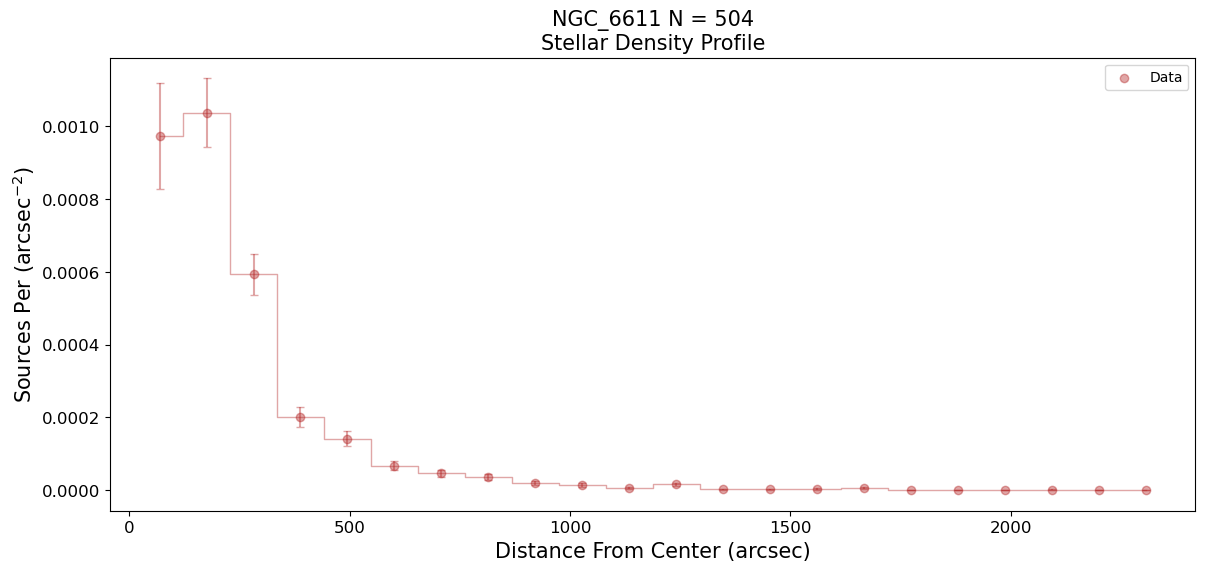

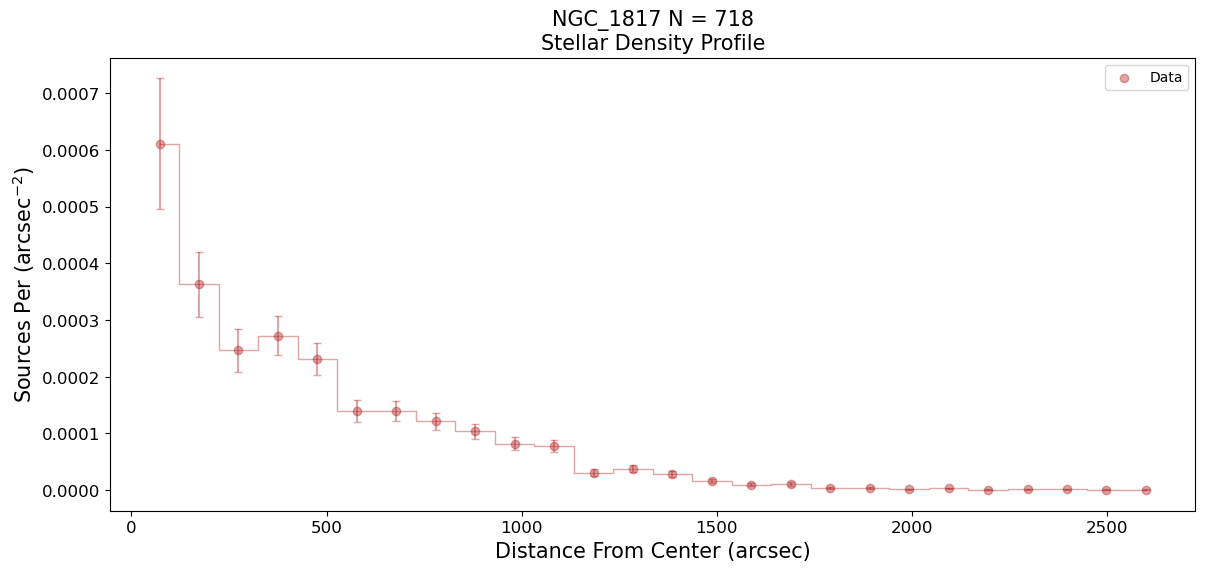

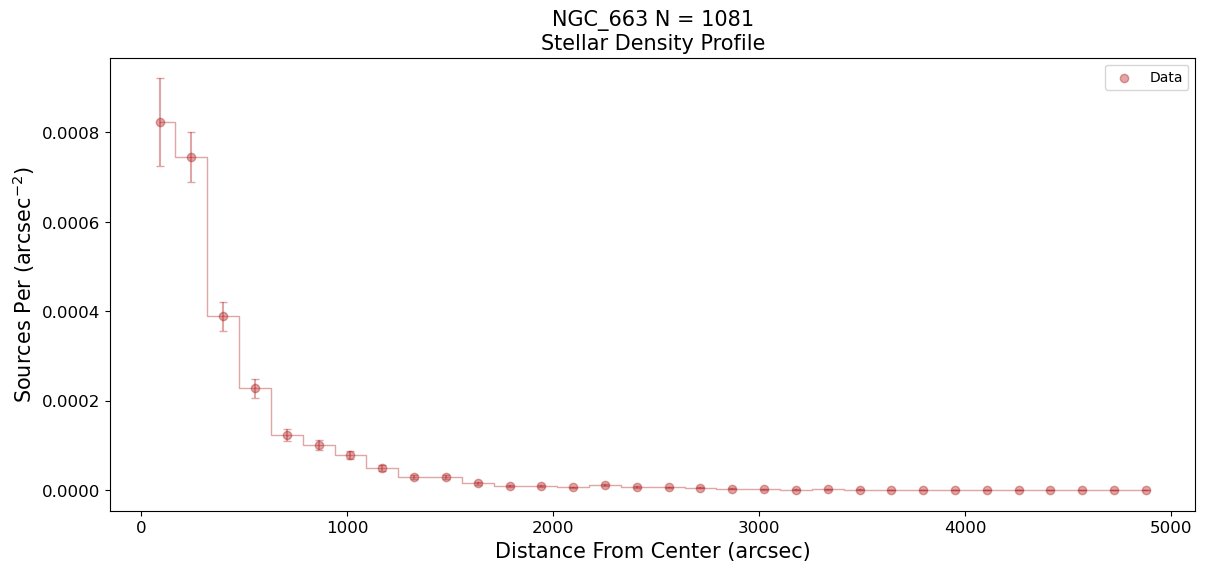

In [91]:
# loop through and plot
for cluster_name in assigned_clusters:
    stellar_density_profile_plot(stars_df, cluster_name)

### 1 Comment

# 2 Task:

Fit the King model to the stellar density profiles of your three clusters to obtain the MLEs for the
parameters and a goodness of fit of the model where appropriate. Plot your data again with the
model fits and residuals or ratios as appropriate.

Obtain 1-sigma confidence intervals on the model parameters, and if the intervals are not closed (i.e. they
include the bounds of the fitted parameters, or zero or infinity), obtain 3-� upper or lower (as
appropriate) limits on the parameters.

Kind Model

$$ \rho(r) = \rho_{0} [\frac{1}{\sqrt{1 + (r/r_{c})^2}} - \frac{1}{\sqrt{1 + (r_t/r_{c})^2}}]^2 + c $$

Where $r< r_c$

where for $r > r_t$, $\rho(r) = c$

Here, �' is a normalization factor, �0 is known as the core radius of the cluster, �/ is the tidal radius
(where the cluster is truncated), and � is a constant which corresponds to the number density of
unassociated foreground/background stars (which may be very small for these data, since the cluster
stars have already been pre-selected based on association in astrometric parameter space). 



* use  lmfit


### Idea:
* We modify our existing plotting function, maybe write a a function to do the fiting and confidence intervals 
* Define king model as its own function


### Assumptions:

In [118]:
# Your King model
def king_model(r, rho_knot, c, r_c, r_t):
    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    rho_king[r > r_t] = c  # for r > r_t, set rho_king = c
    return rho_king


array([7.52577235e-04, 4.46437389e-04, 1.70890961e-04, 9.40571759e-05,
       5.90421162e-05, 2.77234734e-05, 1.87116547e-05, 7.94350700e-06,
       8.53895544e-06, 9.28268679e-06, 6.17836846e-06, 2.93452483e-06,
       1.66193645e-06, 1.53925934e-06, 7.16724127e-07, 6.70624364e-07,
       4.72572374e-07, 2.97093959e-07, 1.40537865e-07, 1.33348213e-07])

In [186]:
def fit_and_plot(stars_df,cluster_name, initial_params, model_func = king_model, nbins=20,
                 param_bounds=None, figsize=(10, 5)):
    # Create an lmfit model from the function
    model = Model(model_func)

    # Set initial parameter values
    params = model.make_params(**initial_params)

    # get data from stars_df
    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=20)  # Adjust the number of bins as needed
                                                                                        # Using SQRT of n rule for the moment

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2) 
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    # For convience 
    x_data = bin_centers
    y_data = stellar_density


    # Set parameter bounds if provided
    if param_bounds:
        for param, bounds in param_bounds.items():
            params[param].min, params[param].max = bounds

    # Fit the model to the data
    result = model.fit(y_data, params=params, r=x_data)

    # Print the fit results
    result.params.pretty_print()

    # Check if the fit has converged
    if not result.success:
        print("Fit did not converge!")

    # Plotting data and fit, and residuals in two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=figsize, dpi=100, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Plot data and fit in the first subplot
    ax1.scatter(x_data, y_data, label='Data', color='teal')
    ax1.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, fmt='none', ecolor='teal', capsize=3, alpha=0.4)
    ax1.plot(x_data, result.best_fit, label='Model Fit', color='firebrick',alpha=0.7)

    ax1.set_ylabel('Sources Per (arcsec$^{-2}$)', size=12)
    ax1.tick_params(axis='both', which='both', labelsize=12)
    ax1.legend(fontsize=12)

    # Plot residuals in the second subplot
    ax2.scatter(x_data, result.residual, label='Residuals', color='k', alpha=0.5)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Distance From Center (arcsec)', size=12)
    ax2.set_ylabel('Residuals', size=12)
    ax2.tick_params(axis='both', which='both', labelsize=12)
   # ax2.set_yscale('log')

    plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
    plt.show()

    # Confidence intervals and parameter limits
    conf_interval = result.conf_interval()
    return result, conf_interval

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
c         2.746e-06    1e-10   0.0001 1.494e-06     True     None     None
r_c          218.1        0    1e+04    5.366     True     None     None
r_t           1365        0    1e+05    112.4     True     None     None
rho_knot  0.002715        0    2e+06 8.349e-05     True     None     None


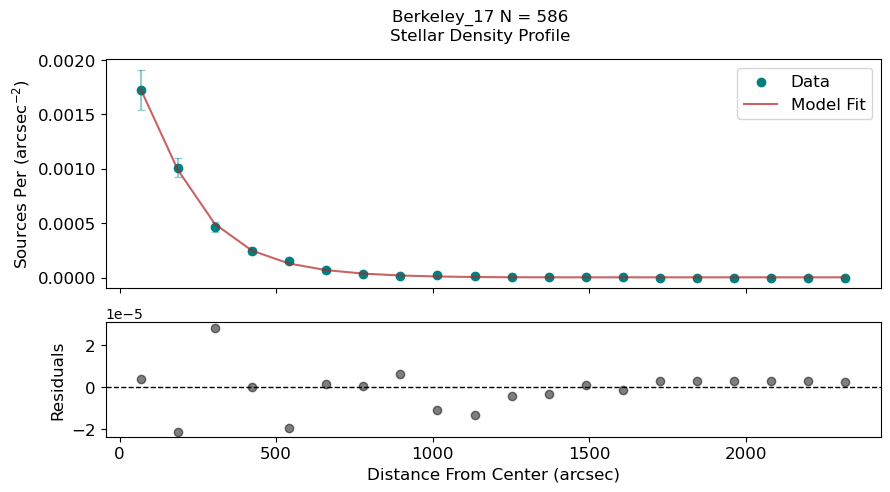

/home/afinemax/anaconda3/lib/python3.9/site-packages/lmfit/confidence.py:317: UserWarning: Bound reached with prob(c=1e-10) = 0.6486667988569396 < max(sigmas)
  warn(errmsg)
/home/afinemax/anaconda3/lib/python3.9/site-packages/lmfit/confidence.py:330: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(c=4.240503296629553e-06) = 0.0 < max(sigmas)
  warn(errmsg)


Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
c         3.825e-07    1e-10   0.0001 9.901e-07     True     None     None
r_c          939.9        0    1e+04    178.6     True     None     None
r_t           5763        0    1e+05     5839     True     None     None
rho_knot  0.0001928        0    2e+06 5.304e-05     True     None     None


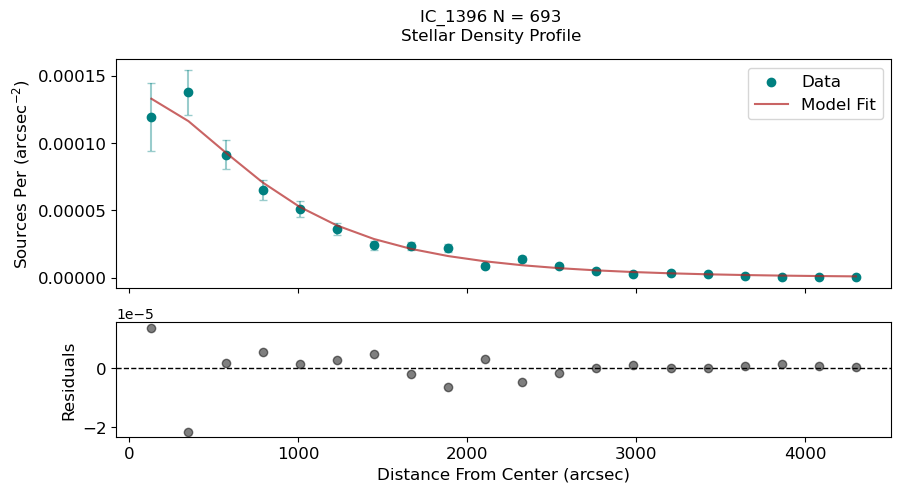

/home/afinemax/anaconda3/lib/python3.9/site-packages/lmfit/confidence.py:317: UserWarning: Bound reached with prob(c=1e-10) = 0.0 < max(sigmas)
  warn(errmsg)
/home/afinemax/anaconda3/lib/python3.9/site-packages/lmfit/confidence.py:317: UserWarning: Bound reached with prob(r_t=100000.0) = 0.9591155457967838 < max(sigmas)
  warn(errmsg)


Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
c         1.384e-05    1e-10   0.0001 5.08e-05     True     None     None
r_c          185.8        0    1e+04    3.963     True     None     None
r_t           1231        0    1e+05    114.9     True     None     None
rho_knot  0.007034        0    2e+06 0.0002243     True     None     None


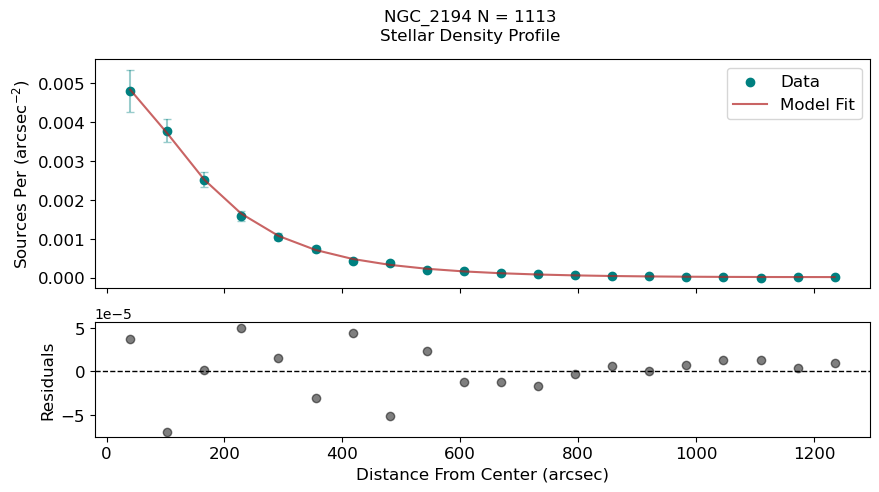

/home/afinemax/anaconda3/lib/python3.9/site-packages/lmfit/confidence.py:317: UserWarning: Bound reached with prob(c=1e-10) = 0.49726180292537125 < max(sigmas)
  warn(errmsg)


In [187]:
 cluster_names = ['Berkeley_17', 'IC_1396', 'NGC_2194']
# assigned_clusters
for cluster_name in cluster_names:

    initial_params = {'rho_knot': 1, 'c': 1, 'r_c': 500, 'r_t': 1000}
    param_bounds = {'c': (1e-10, 1e-4), 'r_c': (0, 1e4), 'r_t': (0, 1e5), 'rho_knot': (0, 2e6)}

    result, conf_interval = fit_and_plot(stars_df,cluster_name, initial_params, model_func = king_model, nbins=20,
                    param_bounds=param_bounds, figsize=(10, 5))